This notebook includes:

- EDA
- Using OLS as a baseline
- Using XGBOOST with different sets of features, always using grid search for choosing the best hyperparameters.

**Packages**

In [31]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from IPython.display import display

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import statsmodels.api as sm

**Helpers Imports**

In [32]:
from helpers.data_extraction import extract_section_7, load_automobile_df
from helpers.eda_functions import (
    show_shape,
    plot_missing_bar,
    plot_missing_heatmap,
    summary_table,
    plot_countplots,
    plot_unique_bar,
    plot_numeric_distributions,
    plot_price_distribution,
    plot_correlation_heatmap,
    plot_pairplot,
    plot_scatter,
    plot_grouped_boxplot,
    plot_grouped_violinplot,
    cramers_v,
    plot_cramers_v_heatmap,
    categorical_numerical_eta_summary,
    plot_eta_squared_heatmap,
    plot_all_boxplots,
    flag_zscore_outliers,
    flag_iqr_outliers,
    outlier_summary
)

from helpers.models import adjusted_r2, run_ols_regression, run_xgboost_cv

**Data Paths**

In [33]:
data_path = "automobile/imports-85.data"
names_path = "automobile/imports-85.names"

In [34]:
df, informations = load_automobile_df(data_path, names_path)

In [35]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [36]:
informations

{'symboling': '-3, -2, -1, 0, 1, 2, 3.',
 'normalized-losses': 'continuous from 65 to 256.',
 'make': 'alfa-romero, audi, bmw, chevrolet, dodge, honda, isuzu, jaguar, mazda, mercedes-benz, mercury, mitsubishi, nissan, peugot, plymouth, porsche, renault, saab, subaru, toyota, volkswagen, volvo',
 'fuel-type': 'diesel, gas.',
 'aspiration': 'std, turbo.',
 'num-of-doors': 'four, two.',
 'body-style': 'hardtop, wagon, sedan, hatchback, convertible.',
 'drive-wheels': '4wd, fwd, rwd.',
 'engine-location': 'front, rear.',
 'wheel-base': 'continuous from 86.6 120.9.',
 'length': 'continuous from 141.1 to 208.1.',
 'width': 'continuous from 60.3 to 72.3.',
 'height': 'continuous from 47.8 to 59.8.',
 'curb-weight': 'continuous from 1488 to 4066.',
 'engine-type': 'dohc, dohcv, l, ohc, ohcf, ohcv, rotor.',
 'num-of-cylinders': 'eight, five, four, six, three, twelve, two.',
 'engine-size': 'continuous from 61 to 326.',
 'fuel-system': '1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi.',
 'bore': 'c

In [37]:
print(df.dtypes)

symboling              int64
normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object


As the variables num-of-cylinders and num-of-doors have string values, despite having numerical meaning, it was decided to convert them to numerical values considering the values that are given.

In [38]:
# To confirm if the list of values matches the one that was given
print("Unique values of num-of-cylinders:", list(df['num-of-cylinders'].unique()))
print("Unique values of num-of-doors:", list(df['num-of-doors'].unique()))

Unique values of num-of-cylinders: ['four', 'six', 'five', 'three', 'twelve', 'two', 'eight']
Unique values of num-of-doors: ['two', 'four', nan]


In [39]:
door_map = {
    'four': 4, 
    'two': 2
}

cyl_map = {
    'eight': 8,
    'five': 5,
    'four': 4,
    'six': 6,
    'three': 3,
    'twelve': 12,
    'two': 2
}

# Convert to integer columns. I put Int64 because one variable  has missing values.
df['num-of-doors'] = df['num-of-doors'].map(door_map).astype('Int64')
df['num-of-cylinders'] = df['num-of-cylinders'].map(cyl_map).astype('Int64')

Variables curb-weight and engine-size are "continuous" and not discrete, so their types were changed.

In [40]:
df['curb-weight'] = df['curb-weight'].astype('float64')
df['engine-size'] = df['engine-size'].astype('float64')

A. Data Health and Structure

In [41]:
show_shape(df)

Number of rows: 205
Number of columns: 26


In [42]:
for col in df.columns:
    pct_missing = df[col].isna().sum() / df.shape[0] * 100
    print(f"{col:22} {pct_missing:7.2f}%")

symboling                 0.00%
normalized-losses        20.00%
make                      0.00%
fuel-type                 0.00%
aspiration                0.00%
num-of-doors              0.98%
body-style                0.00%
drive-wheels              0.00%
engine-location           0.00%
wheel-base                0.00%
length                    0.00%
width                     0.00%
height                    0.00%
curb-weight               0.00%
engine-type               0.00%
num-of-cylinders          0.00%
engine-size               0.00%
fuel-system               0.00%
bore                      1.95%
stroke                    1.95%
compression-ratio         0.00%
horsepower                0.98%
peak-rpm                  0.98%
city-mpg                  0.00%
highway-mpg               0.00%
price                     1.95%


c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_df.values, y=missing_df.index, palette="Blues_r")


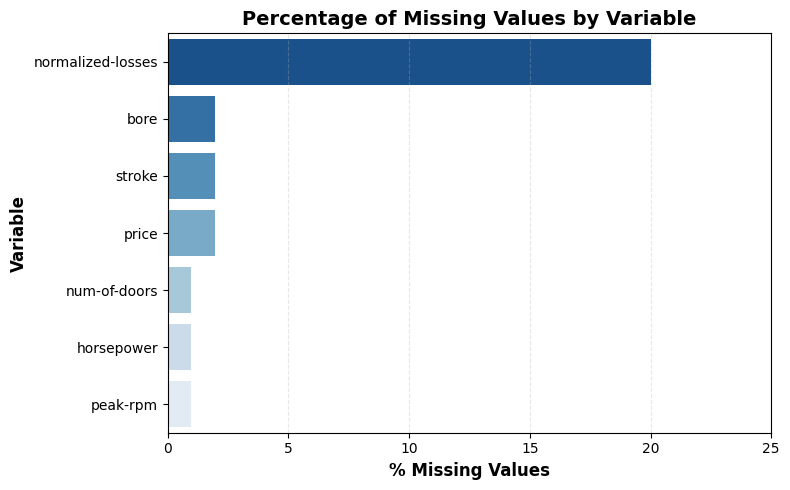

In [43]:
plot_missing_bar(df)

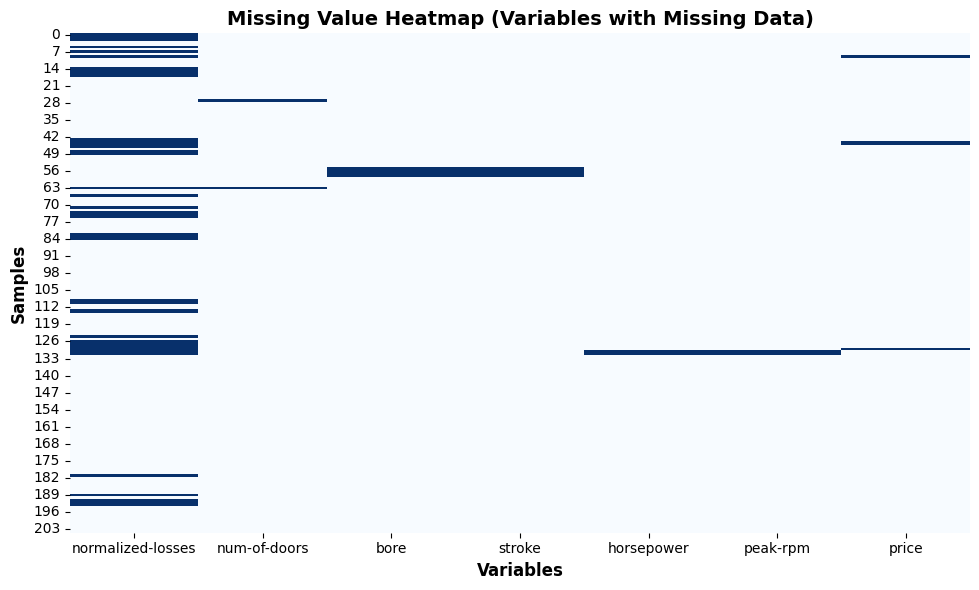

In [44]:
plot_missing_heatmap(df)

In [45]:
summary_table(df)


Numerical Variables Summary:


,count,missing_pct,n_unique,mean,std,min,25%,50%,75%,max,skew,kurtosis,mode
symboling,205.0,0.00000,6,0.834146,1.245307,-2.0,0.0,1.0,2.0,3.0,0.211072,-0.676271,0.0
normalized-losses,164.0,20.00000,51,122.0,35.442168,65.0,94.0,115.0,150.0,256.0,0.765976,0.52544,161.0
num-of-doors,203.0,0.97561,2,3.123153,0.994841,2.0,2.0,4.0,4.0,4.0,-0.250046,-1.956855,4.0
wheel-base,205.0,0.00000,53,98.756585,6.021776,86.6,94.5,97.0,102.4,120.9,1.050214,1.017039,94.5
length,205.0,0.00000,75,174.049268,12.337289,141.1,166.3,173.2,183.1,208.1,0.155954,-0.082895,157.3
width,205.0,0.00000,44,65.907805,2.145204,60.3,64.1,65.5,66.9,72.3,0.904003,0.702764,63.8
height,205.0,0.00000,49,53.724878,2.443522,47.8,52.0,54.1,55.5,59.8,0.063123,-0.443812,50.8
curb-weight,205.0,0.00000,171,2555.565854,520.680204,1488.0,2145.0,2414.0,2935.0,4066.0,0.681398,-0.042854,2385.0
num-of-cylinders,205.0,0.00000,7,4.380488,1.080854,2.0,4.0,4.0,4.0,12.0,2.817459,13.714866,4.0
engine-size,205.0,0.00000,44,126.907317,41.642693,61.0,97.0,120.0,141.0,326.0,1.947655,5.305682,92.0



Categorical Variables Summary:


,count,missing_pct,unique,top,freq,2nd_mode,2nd_mode_freq
make,205,0.0,22,toyota,32,nissan,18
fuel-type,205,0.0,2,gas,185,diesel,20
aspiration,205,0.0,2,std,168,turbo,37
body-style,205,0.0,5,sedan,96,hatchback,70
drive-wheels,205,0.0,3,fwd,120,rwd,76
engine-location,205,0.0,2,front,202,rear,3
engine-type,205,0.0,7,ohc,148,ohcf,15
fuel-system,205,0.0,8,mpfi,94,2bbl,66


 For numerical features, I summarized key statistics like mean, median, minimum, maximum, skewness, and kurtosis. For instance, price (the likely target variable) has a wide range (max = 45,400, min = 5,112), high standard deviation, and is positively skewed (skew = 1.81), indicating a few very high-priced outliers.

Some variables, like engine-size, curb-weight, and width, also show substantial variation.
The categorical variables were summarized by their number of unique values, most common category, and frequency. For example, make has 22 unique values with toyota being the most frequent, and fuel-type is mainly gas, with a smaller proportion being diesel.


B. Variable type and distribution exploration

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")


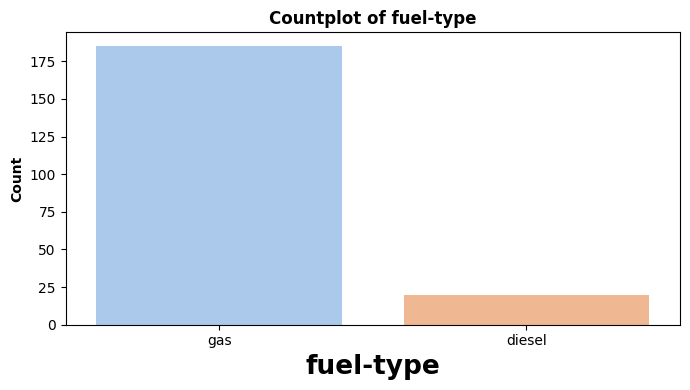

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")


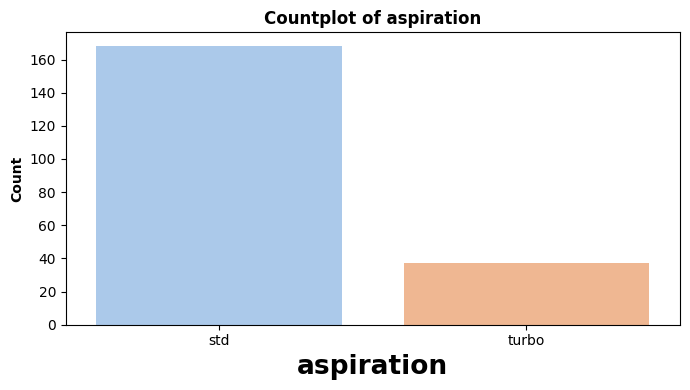

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")


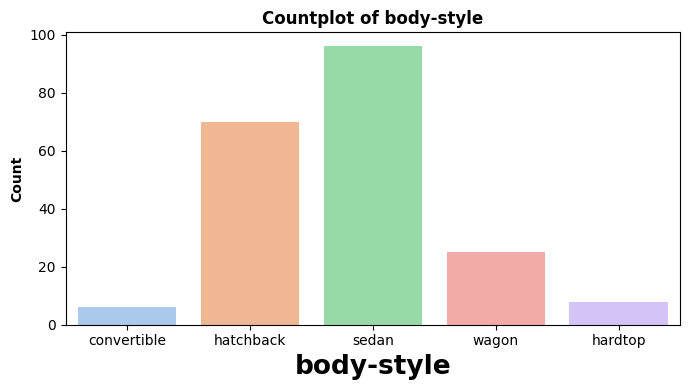

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")


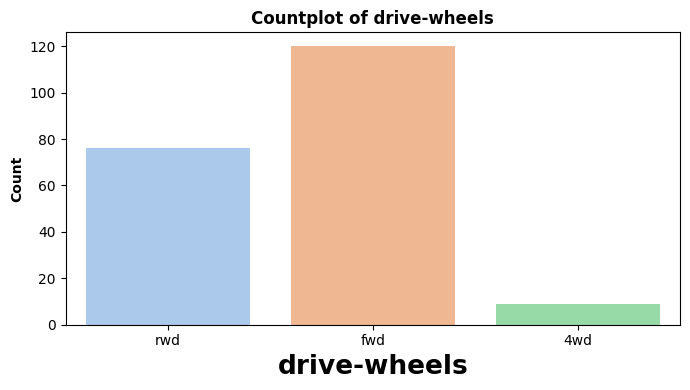

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")


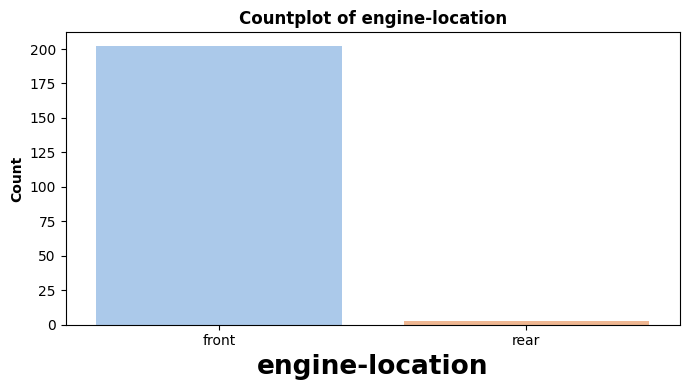

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")


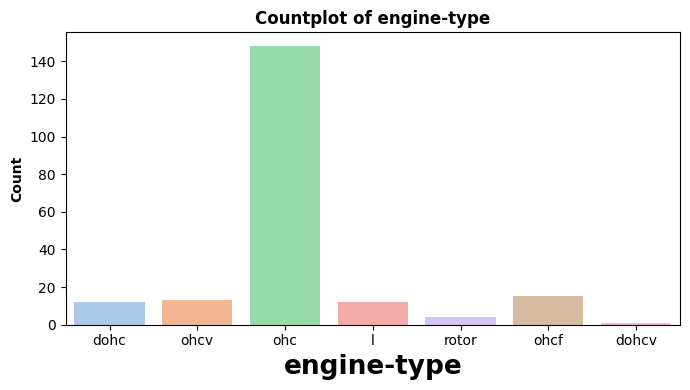

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="pastel")


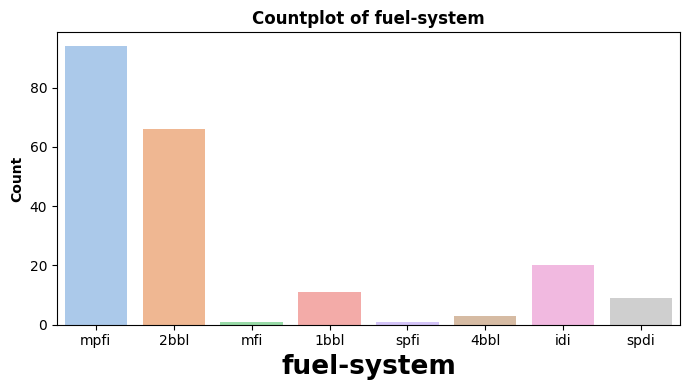

In [46]:
plot_countplots(df)        

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_counts.values, y=unique_counts.index, palette="Blues_r")


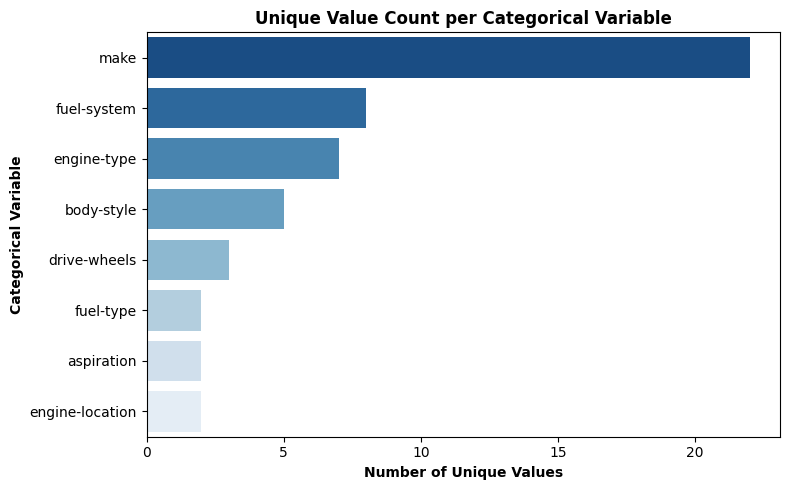

In [47]:
plot_unique_bar(df, max_unique=25)

The variable 'make' is the only one with more than 8 possible values. This variable should be analysed carefully maybe see if LLM solution can help or if it's okay to have that number of distinct values.

In [48]:
df_make_pct = df['make'].value_counts(normalize=True).mul(100)
print(df_make_pct)  

make
toyota           15.609756
nissan            8.780488
mazda             8.292683
mitsubishi        6.341463
honda             6.341463
volkswagen        5.853659
subaru            5.853659
peugot            5.365854
volvo             5.365854
dodge             4.390244
mercedes-benz     3.902439
bmw               3.902439
audi              3.414634
plymouth          3.414634
saab              2.926829
porsche           2.439024
isuzu             1.951220
jaguar            1.463415
chevrolet         1.463415
alfa-romero       1.463415
renault           0.975610
mercury           0.487805
Name: proportion, dtype: float64


c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=axes[0], palette='Blues')


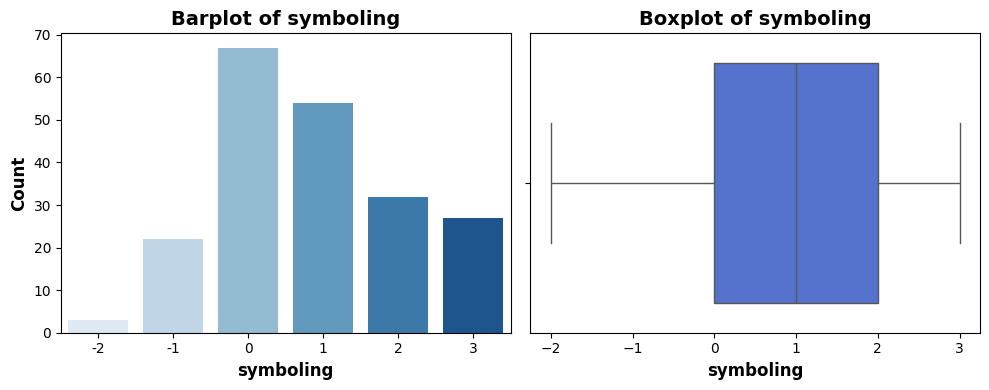

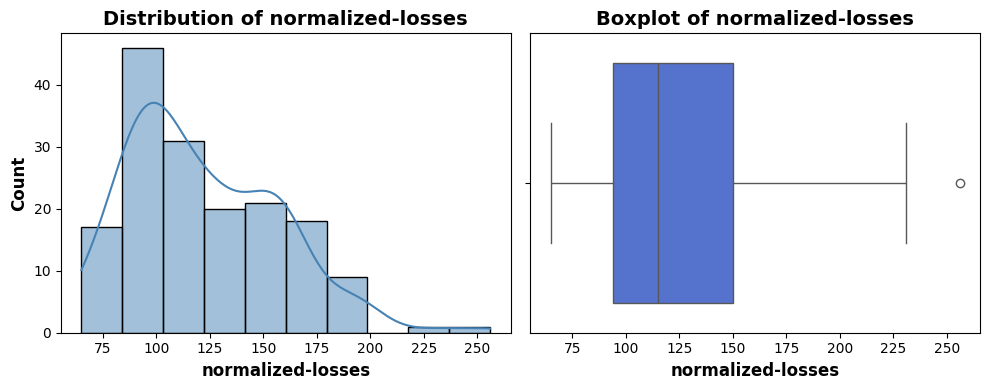

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=axes[0], palette='Blues')


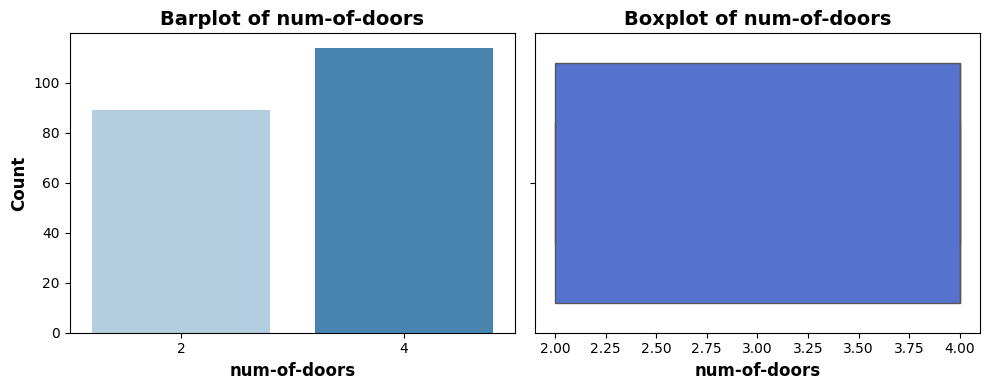

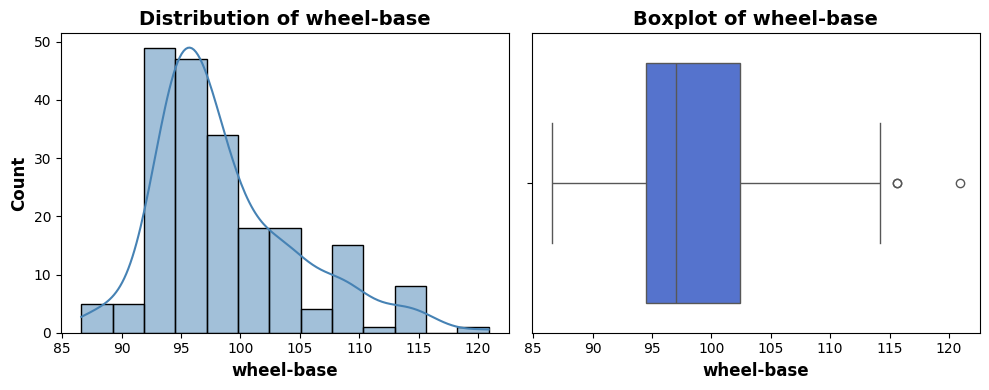

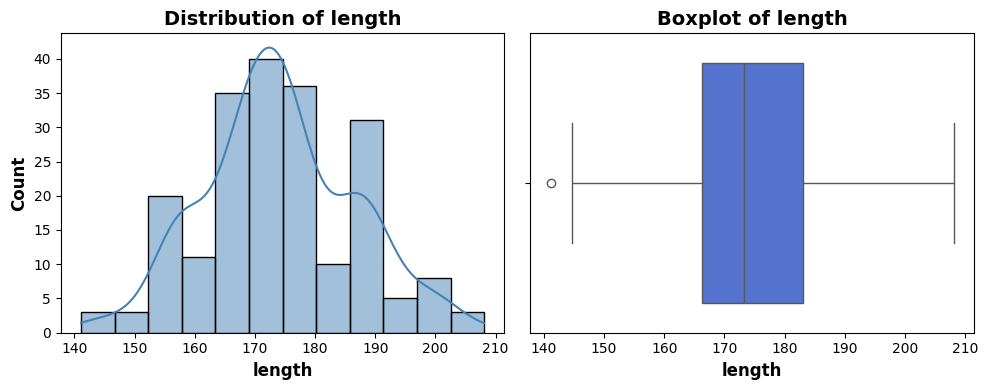

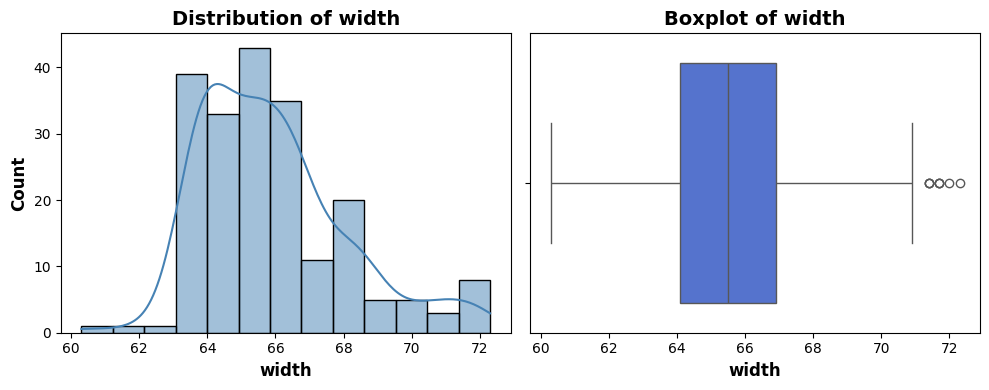

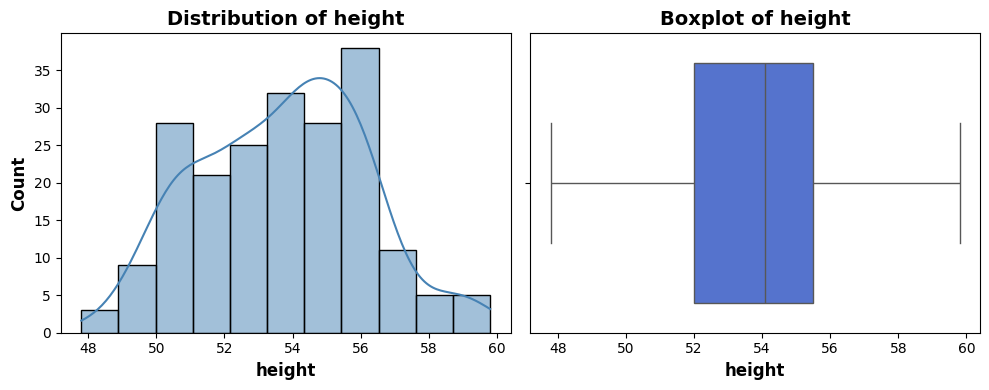

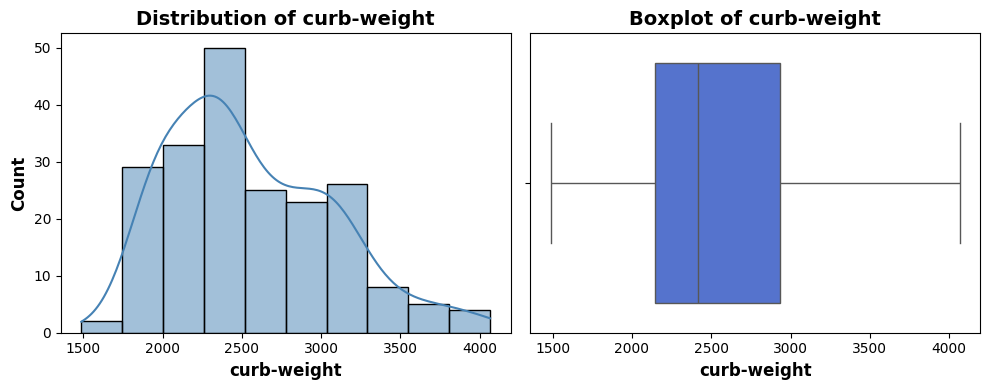

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=axes[0], palette='Blues')


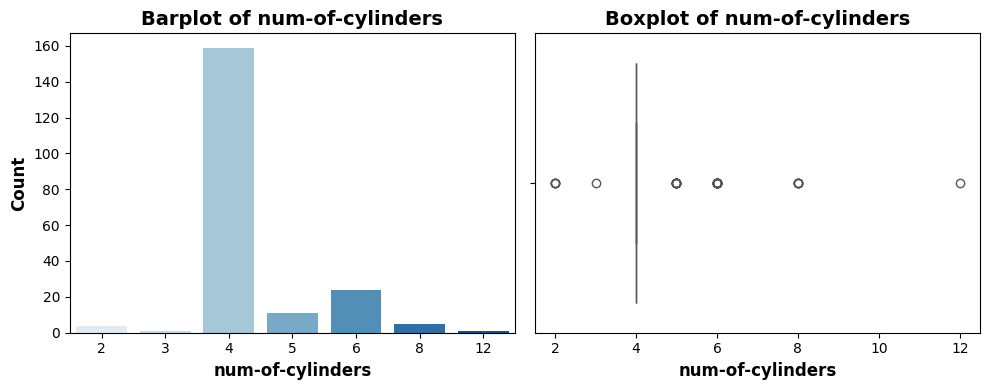

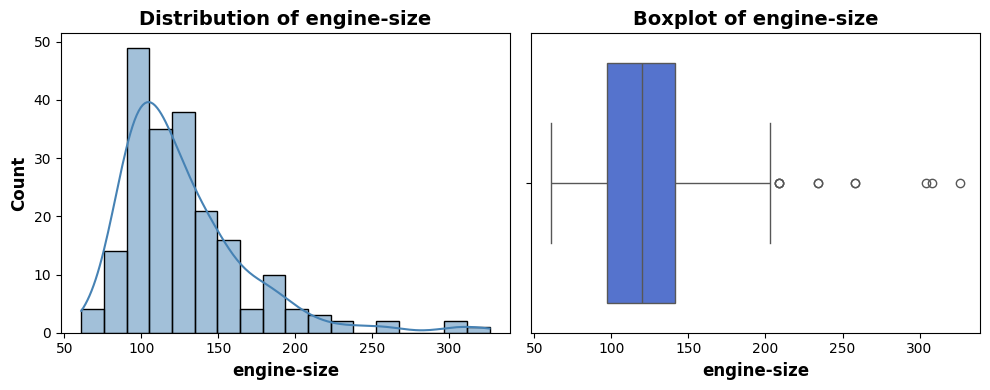

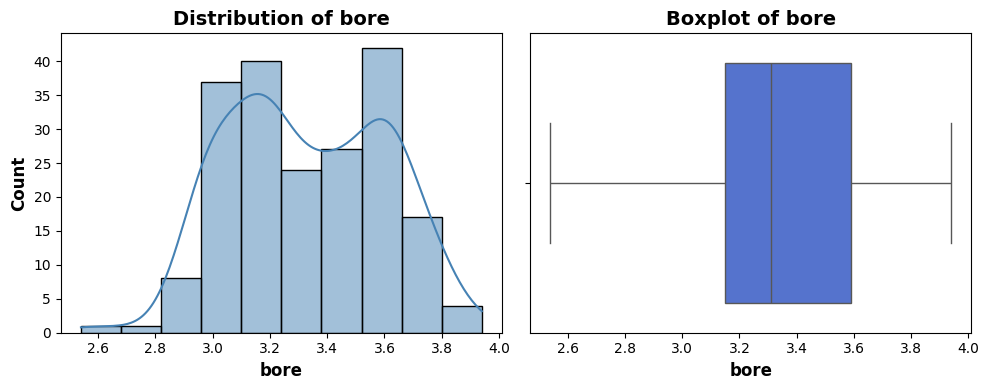

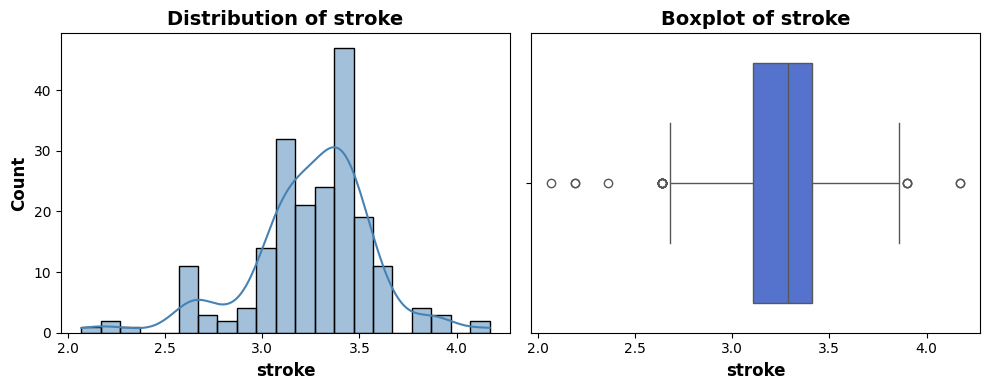

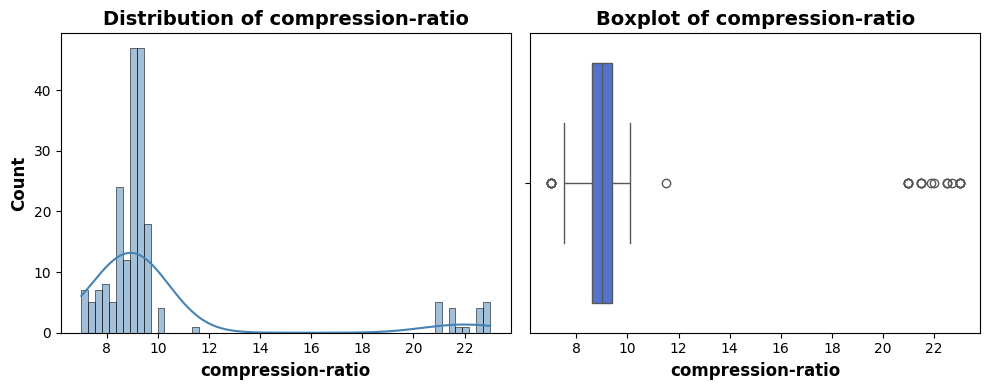

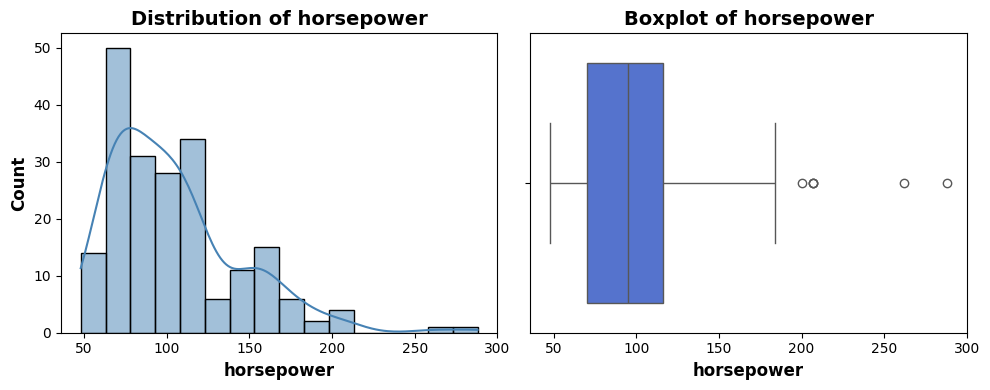

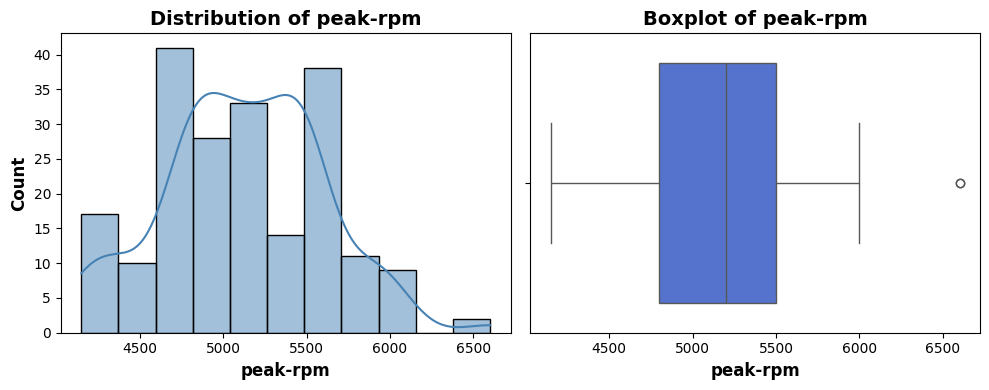

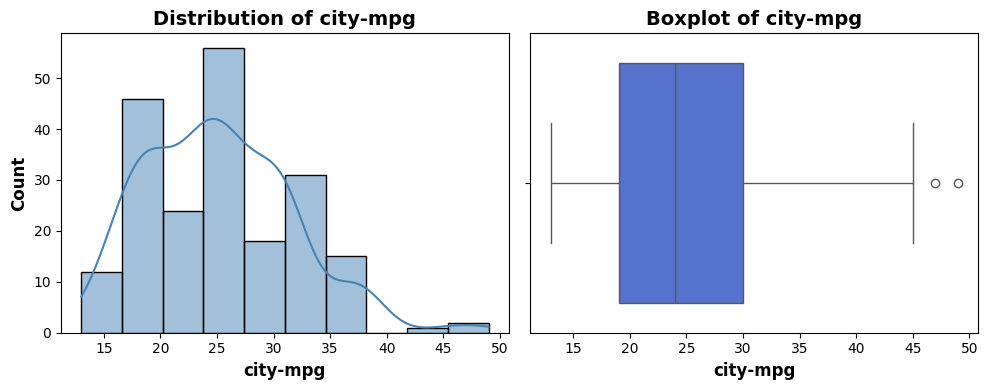

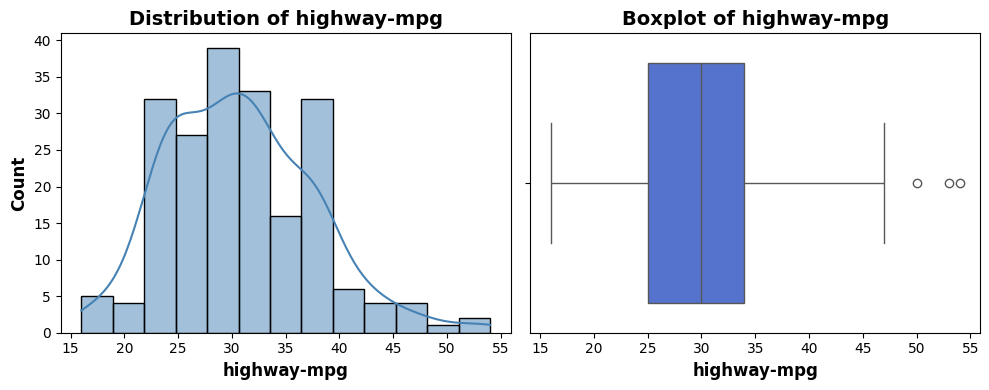

In [49]:
plot_numeric_distributions(df)

Most variables, like wheel-base and length, have values concentrated around an average, but some, such as normalized-losses and wheel-base, have a right-skew with a few higher values.

Outliers are present in several variables, especially normalized-losses and wheel-base, where some cars differ noticeably from the majority. Length appears roughly symmetric—almost like a normal distribution—while symboling is a discrete category with distinct peaks.

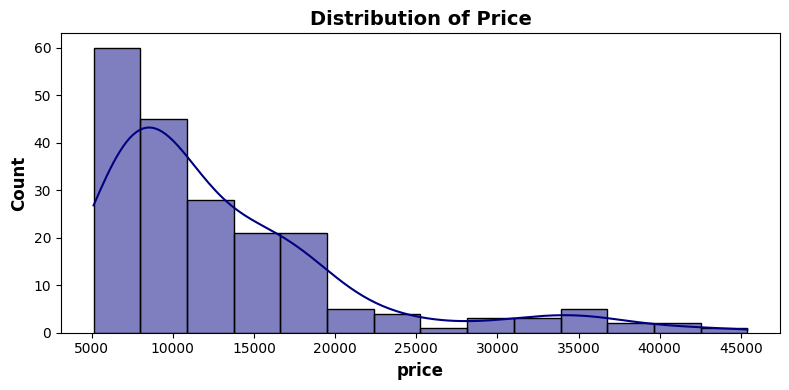

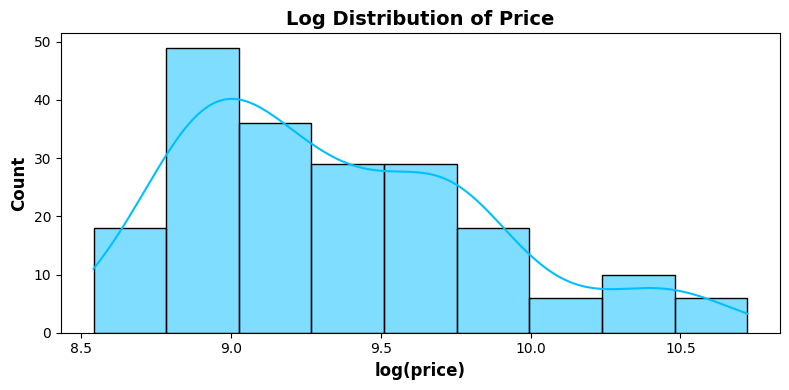

In [50]:
plot_price_distribution(df)

In [51]:
df_price = df.copy()

In [52]:
df_price['price_bin'] = pd.qcut(df_price['price'], 4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

C:\Users\bruno.melgao\AppData\Local\Temp\ipykernel_19100\3761766519.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_bin', y='price', data=df_price, palette='Blues')


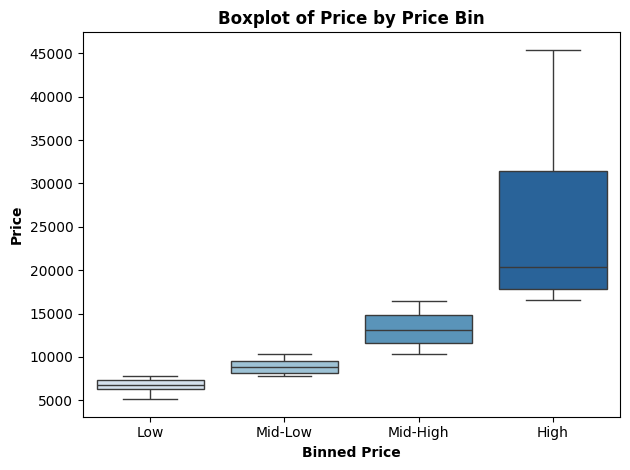

In [53]:
sns.boxplot(x='price_bin', y='price', data=df_price, palette='Blues')
plt.title("Boxplot of Price by Price Bin", fontweight='bold')
plt.xlabel("Binned Price", fontweight='bold')
plt.ylabel("Price", fontweight='bold')
plt.tight_layout()
plt.show()

C. Relationships & Correlations

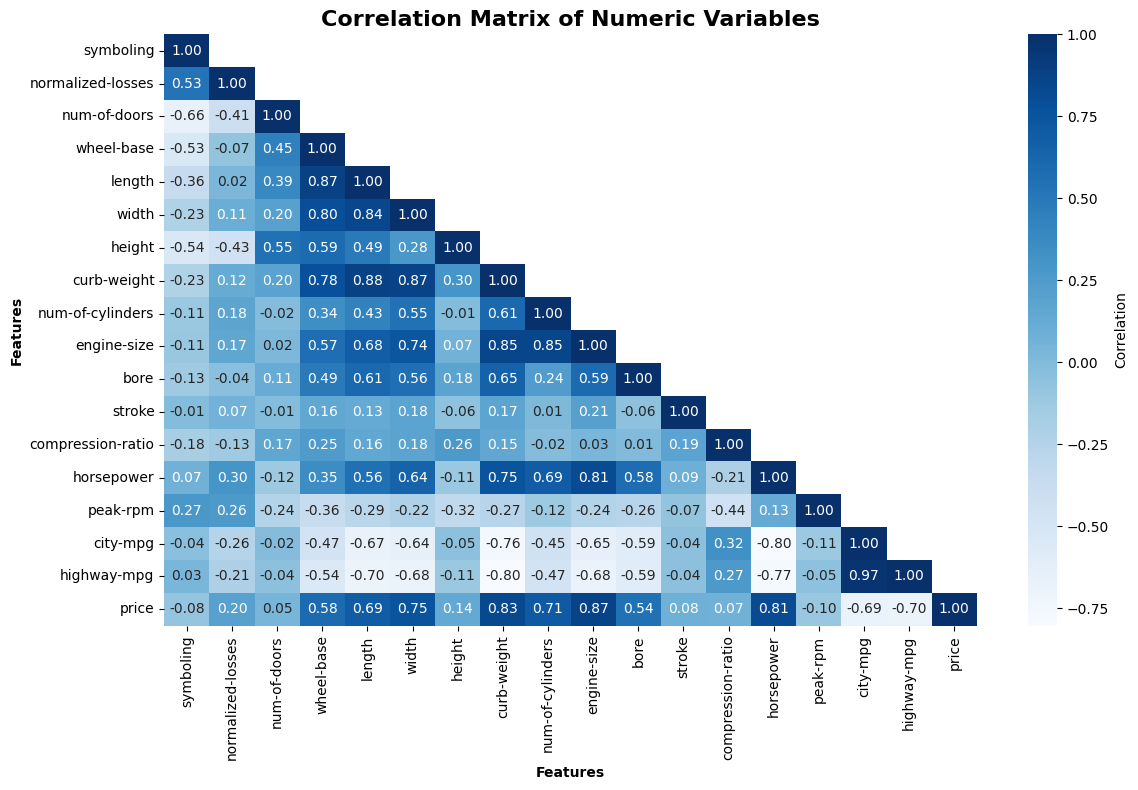

In [54]:
plot_correlation_heatmap(df)

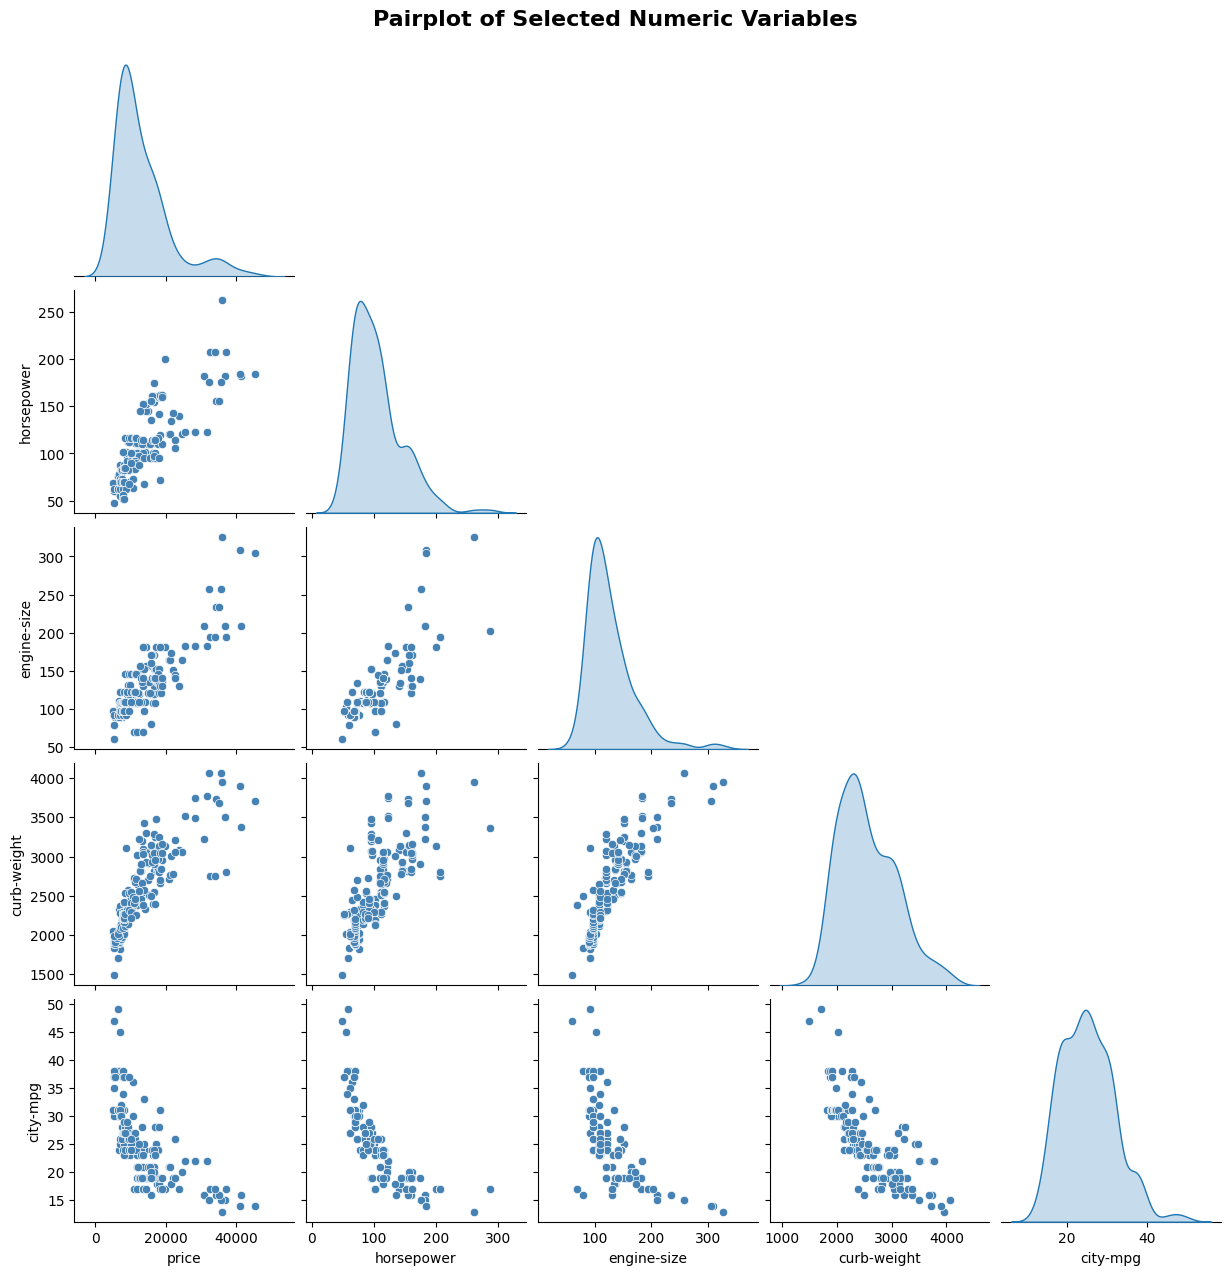

In [55]:
num_pair_cols = ['price', 'horsepower', 'engine-size', 'curb-weight', 'city-mpg']
plot_pairplot(df, num_pair_cols)

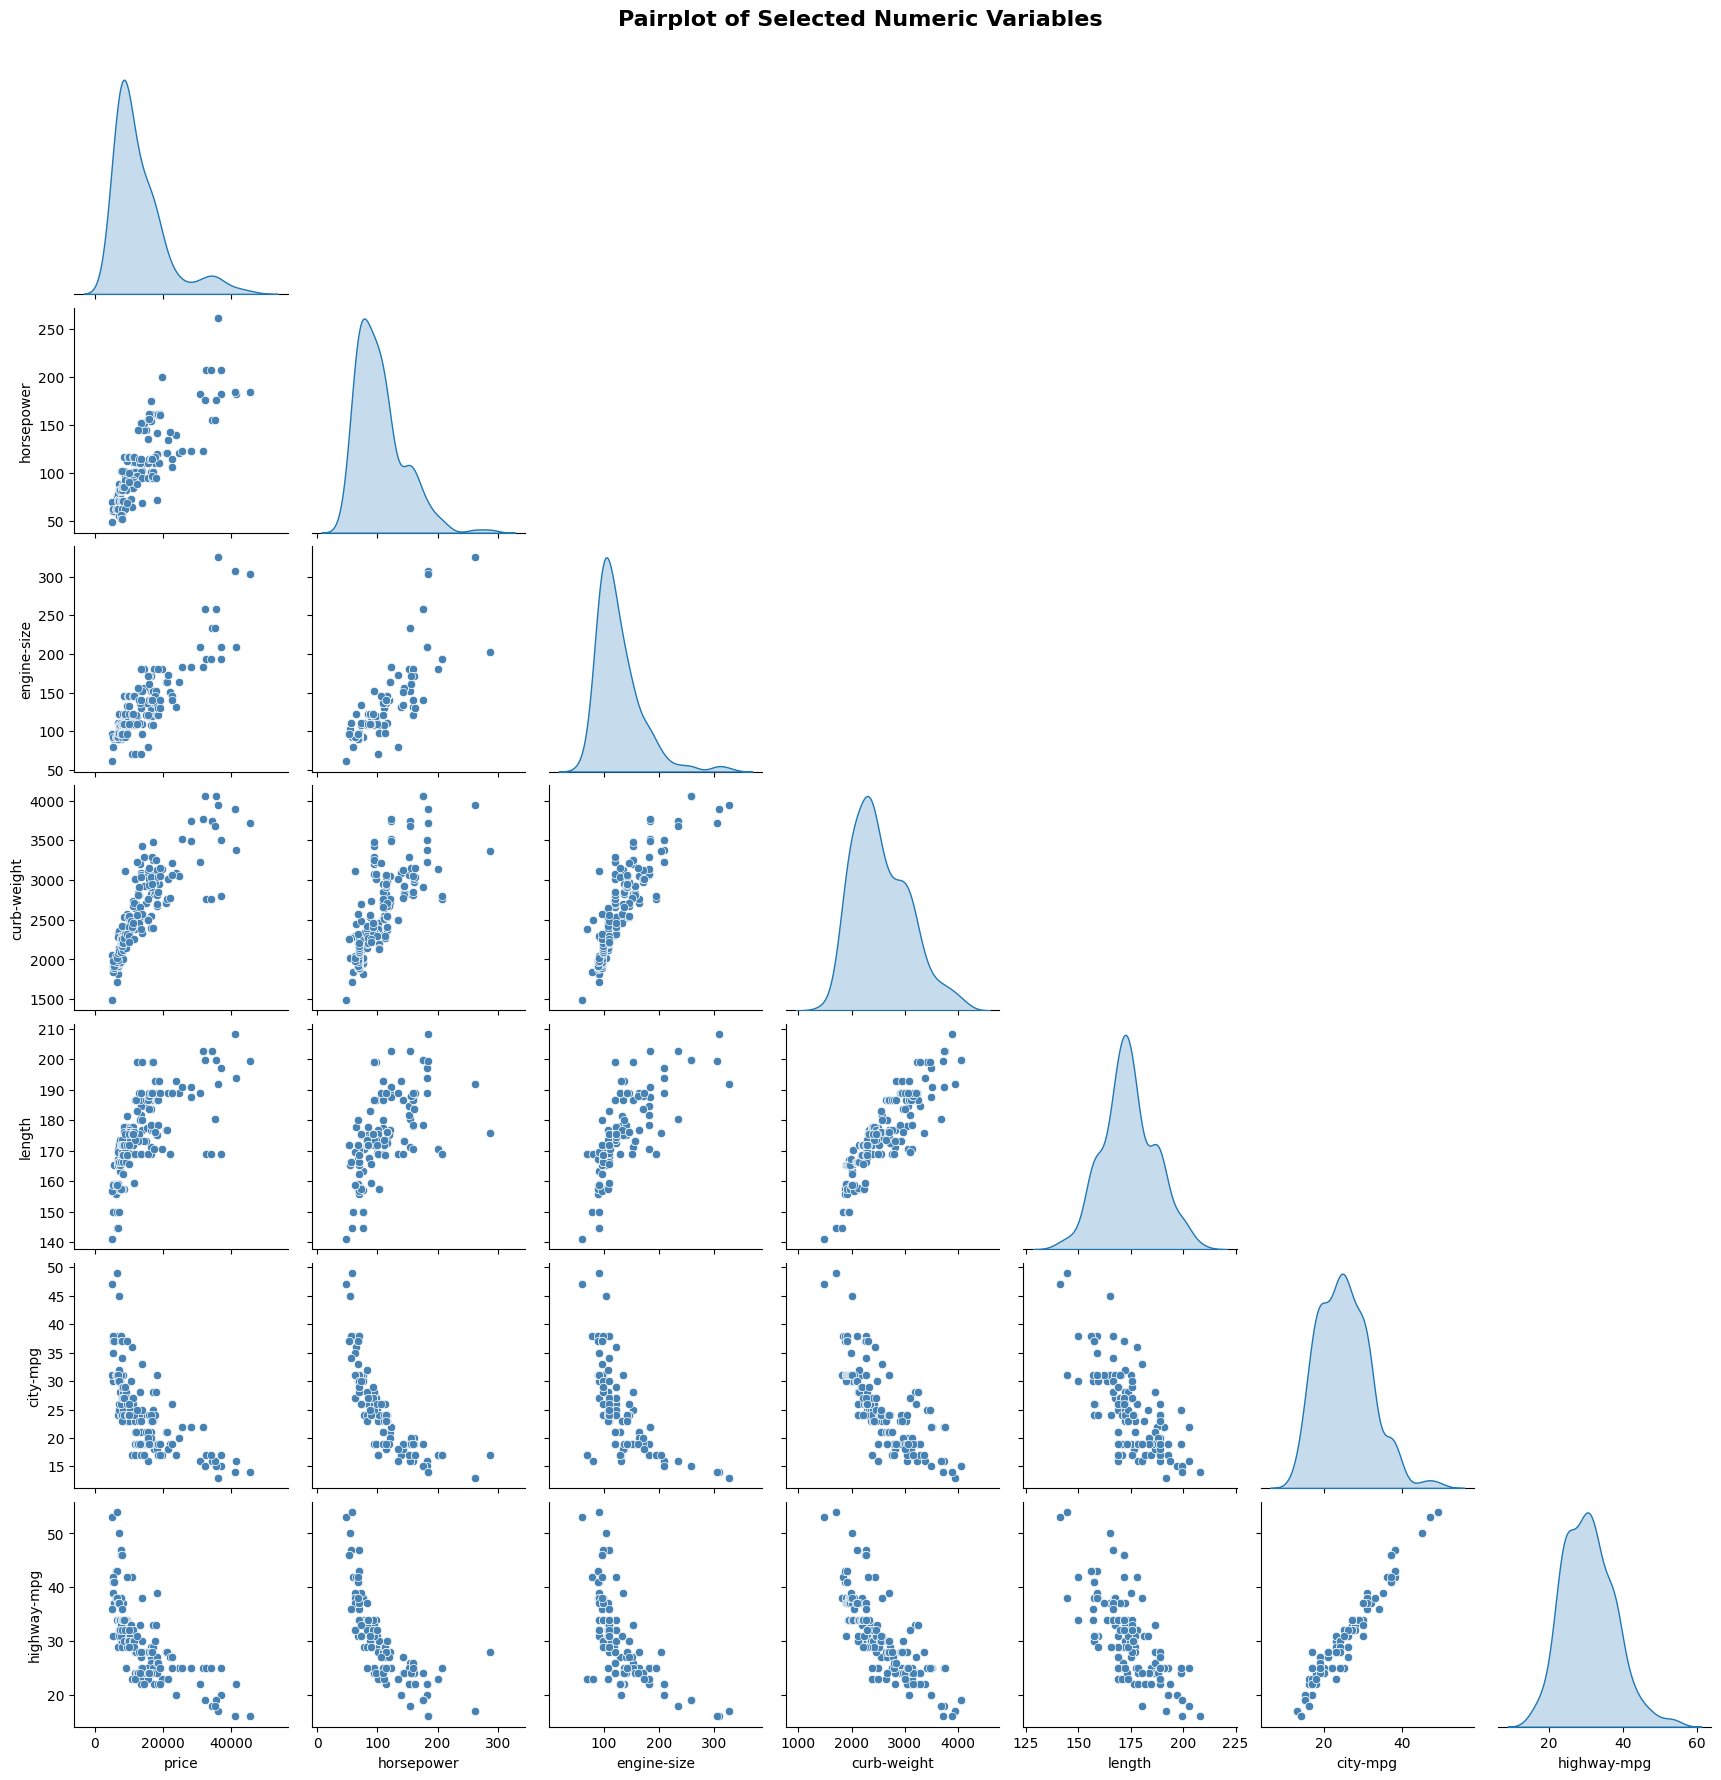

In [56]:
num_pair_cols = ['price', 'horsepower', 'engine-size', 'curb-weight', 'length', 'city-mpg','highway-mpg']
plot_pairplot(df, num_pair_cols)

This pairplot shows clear positive relationships between price, horsepower, engine-size, and curb-weight: as one increases, the others tend to increase too. In contrast, city-mpg has a strong negative relationship with the other variables, meaning cars with more power or bigger engines generally get lower gas mileage. The density plots on the diagonal also highlight that most cars are clustered in the lower ranges for price and engine size, but a few high-performance, expensive outliers stand out.

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:232: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='Blues', alpha=0.7)


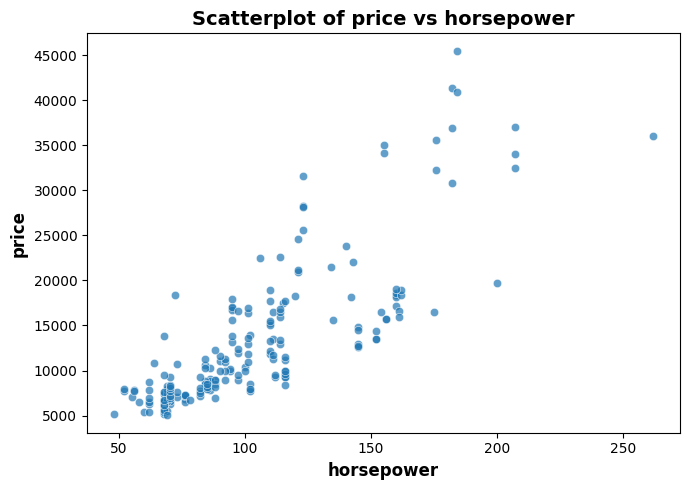

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:232: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='Blues', alpha=0.7)


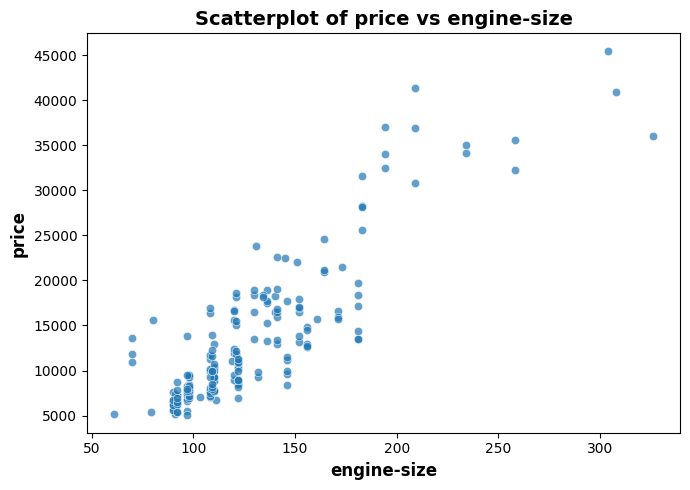

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:232: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='Blues', alpha=0.7)


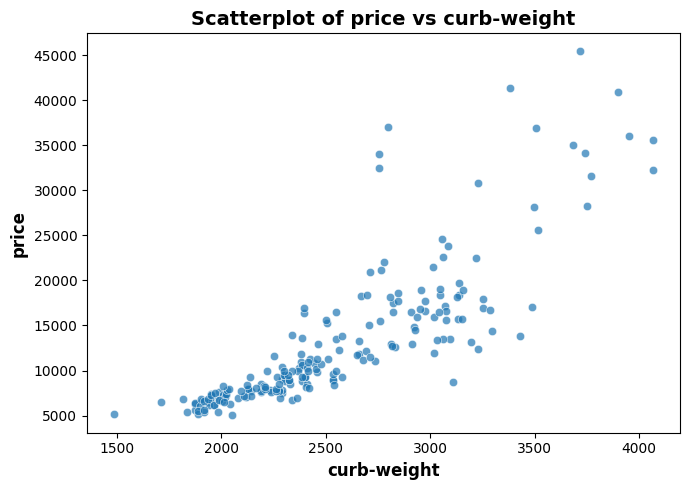

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:232: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='Blues', alpha=0.7)


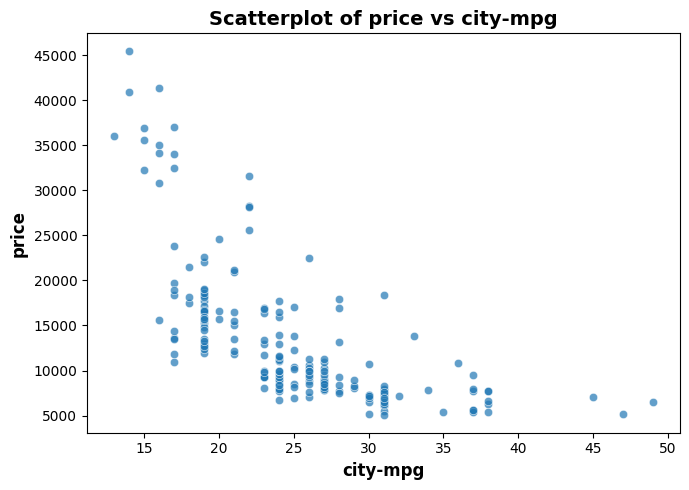

In [57]:
plot_scatter(df, 'horsepower', 'price')
plot_scatter(df, 'engine-size', 'price')
plot_scatter(df, 'curb-weight', 'price')
plot_scatter(df, 'city-mpg', 'price')

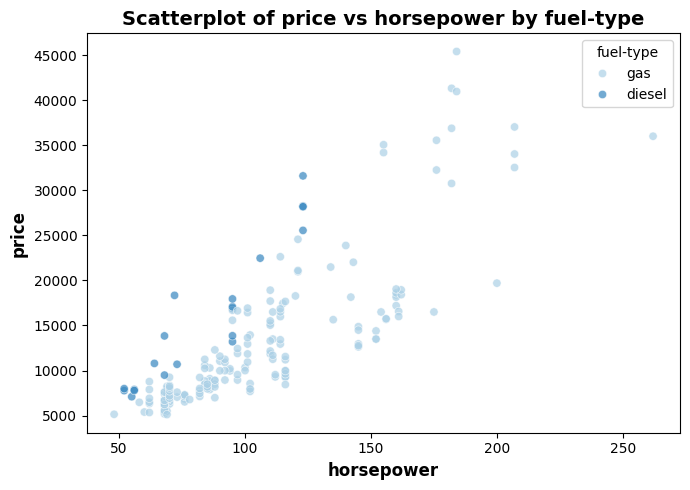

In [58]:
plot_scatter(df, 'horsepower', 'price', hue_col='fuel-type')

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:250: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_col, y=num_col, data=df, palette="Blues")


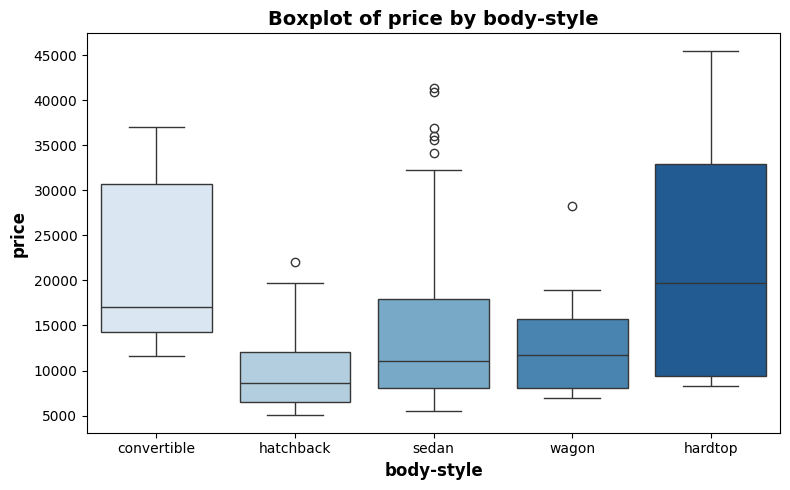

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:250: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_col, y=num_col, data=df, palette="Blues")


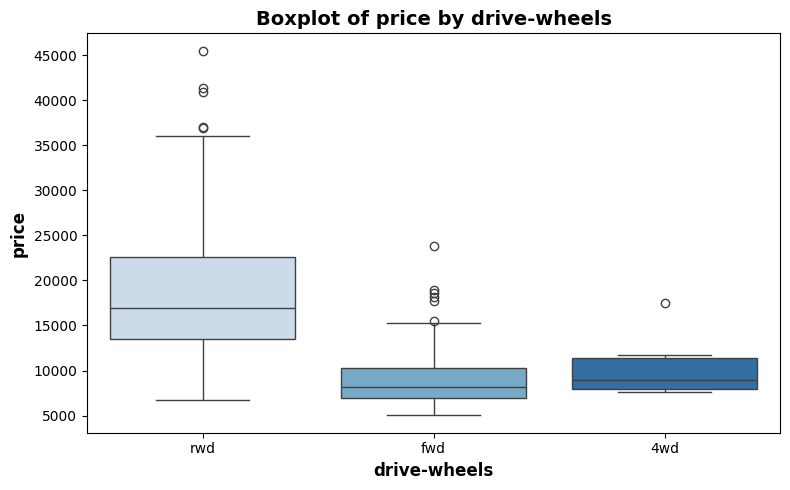

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:250: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_col, y=num_col, data=df, palette="Blues")


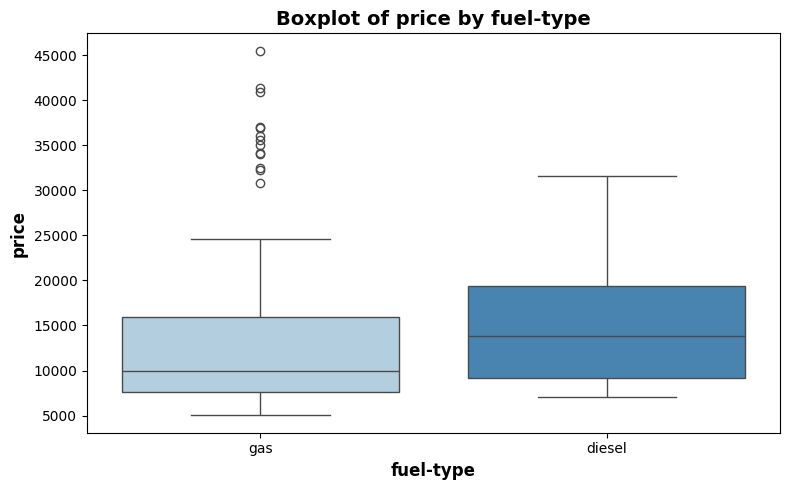

In [59]:
plot_grouped_boxplot(df, 'price', 'body-style')
plot_grouped_boxplot(df, 'price', 'drive-wheels')
plot_grouped_boxplot(df, 'price', 'fuel-type')

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:267: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=cat_col, y=num_col, data=df, palette="Blues")


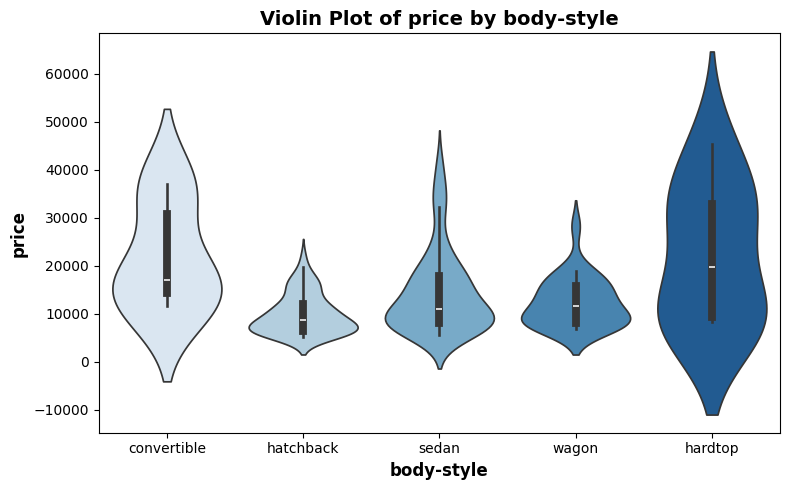

c:\Users\bruno.melgao\OneDrive - Claranet\Documents\Bruno folder\helpers\eda_functions.py:267: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=cat_col, y=num_col, data=df, palette="Blues")


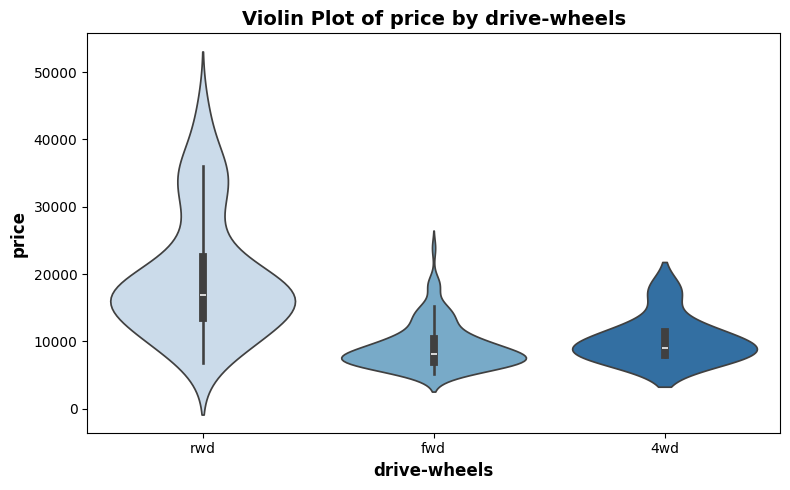

In [60]:
plot_grouped_violinplot(df, 'price', 'body-style')
plot_grouped_violinplot(df, 'price', 'drive-wheels')

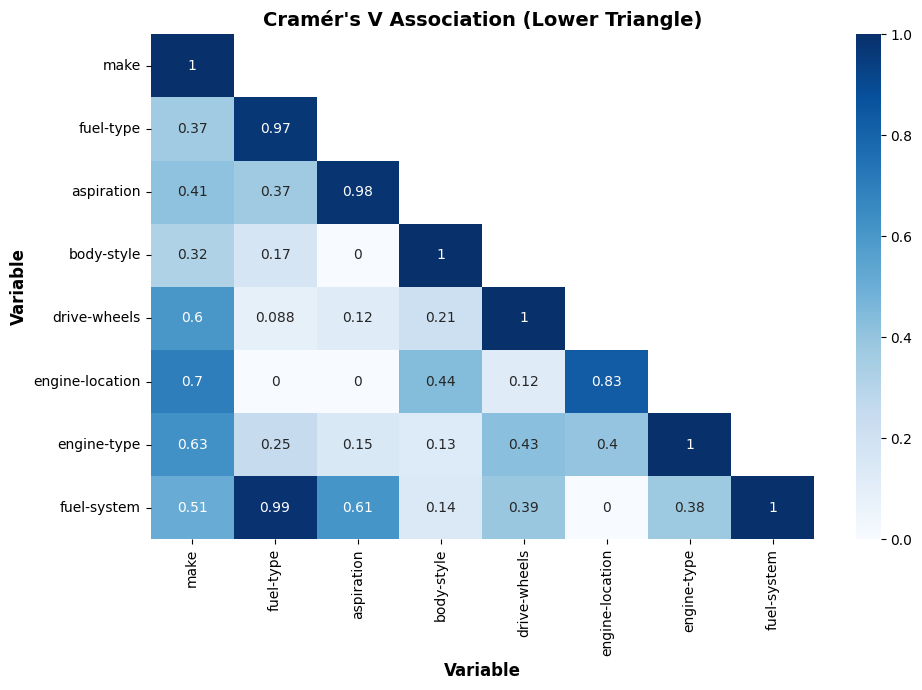

In [61]:
plot_cramers_v_heatmap(df)

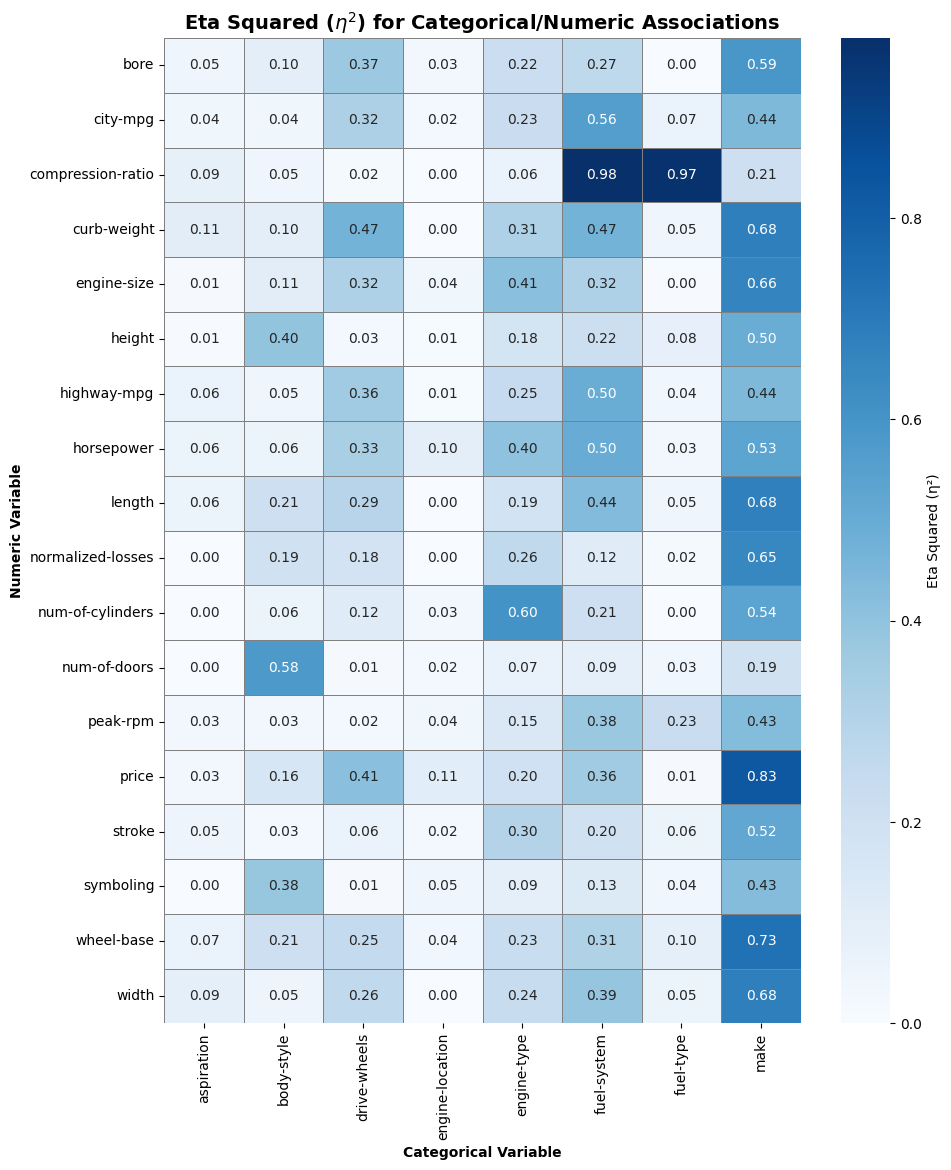

In [62]:
eta_df=categorical_numerical_eta_summary(df)
plot_eta_squared_heatmap(eta_df)

D. Outlier Detection

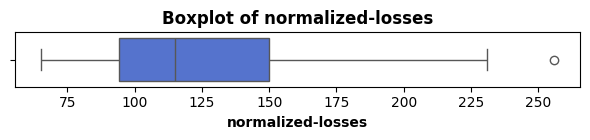

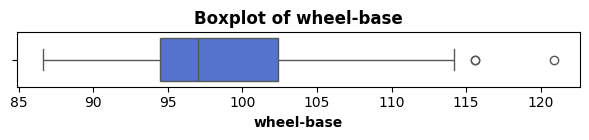

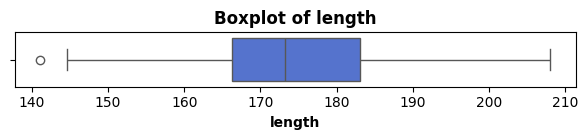

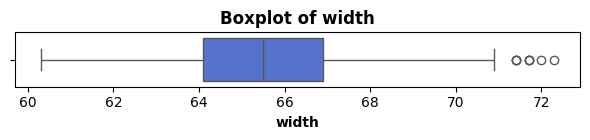

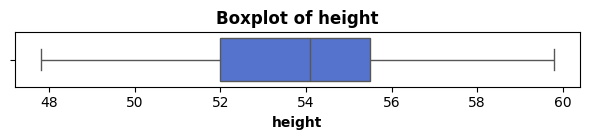

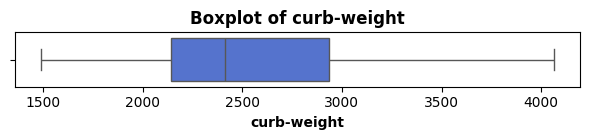

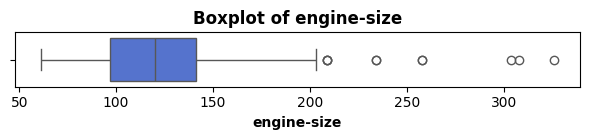

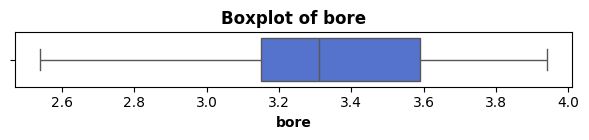

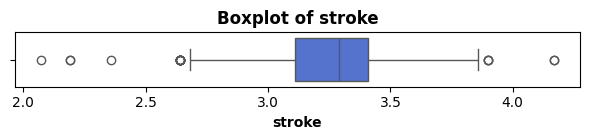

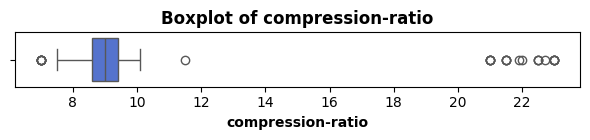

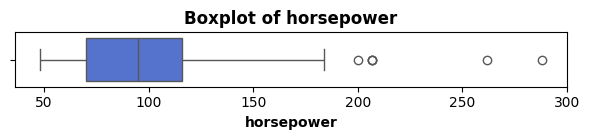

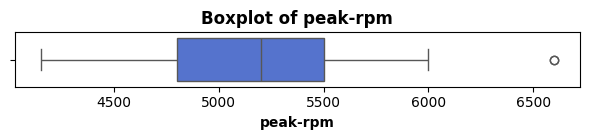

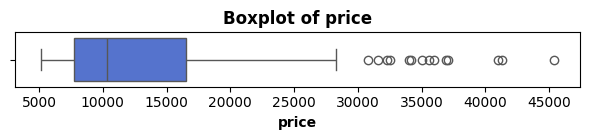

In [63]:
plot_all_boxplots(df)

In [64]:
outlier_summary(df, method='iqr') 

,Variable,Num Outliers,% Outliers,Min,Max
0,normalized-losses,1,0.5%,65.00,256.00
1,wheel-base,3,1.5%,86.60,120.90
2,length,1,0.5%,141.10,208.10
3,width,8,3.9%,60.30,72.30
4,height,0,0.0%,47.80,59.80
5,curb-weight,0,0.0%,1488.00,4066.00
6,engine-size,10,4.9%,61.00,326.00
7,bore,0,0.0%,2.54,3.94
8,stroke,20,9.8%,2.07,4.17
9,compression-ratio,28,13.7%,7.00,23.00


In [65]:
outlier_summary(df, method='zscore', thresh=3) 

,Variable,Num Outliers,% Outliers,Min,Max
0,normalized-losses,2,1.0%,65.00,256.00
1,wheel-base,1,0.5%,86.60,120.90
2,length,0,0.0%,141.10,208.10
3,width,0,0.0%,60.30,72.30
4,height,0,0.0%,47.80,59.80
5,curb-weight,0,0.0%,1488.00,4066.00
6,engine-size,5,2.4%,61.00,326.00
7,bore,0,0.0%,2.54,3.94
8,stroke,3,1.5%,2.07,4.17
9,compression-ratio,9,4.4%,7.00,23.00


MODEL COMPONENT

In [66]:
df.dtypes

symboling              int64
normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
num-of-doors           Int64
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight          float64
engine-type           object
num-of-cylinders       Int64
engine-size          float64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

In [67]:
run_ols_regression(df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     82.99
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           1.70e-51
Time:                        16:25:34   Log-Likelihood:                -1040.1
No. Observations:                 127   AIC:                             2176.
Df Residuals:                      79   BIC:                             2313.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1861.4202 

{'rmse': 1819.0021706887528,
 'mae': 1398.6836180575256,
 'r2': 0.8140580114194921,
 'adj_r2': nan,
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2b5ce9c00a0>,
 'importances': body-style_hatchback    6.182321
 body-style_hardtop      5.505362
 body-style_sedan        5.451682
 body-style_wagon        4.936147
 make_peugot             4.851878
 make_mitsubishi         4.085523
 make_dodge              4.055470
 wheel-base              3.919925
 make_plymouth           3.790644
 aspiration_turbo        3.325940
 make_toyota             3.143285
 make_honda              2.677610
 height                  2.654208
 make_mazda              2.626565
 curb-weight             2.599598
 make_nissan             2.570817
 make_volkswagen         2.568427
 length                  2.481637
 make_porsche            2.374143
 make_chevrolet          2.224729
 width                   2.137678
 city-mpg                1.963795
 make_subaru             1.816877
 engine-type

Although the OLS model shows good performance, it can be affected by multicollinearity issues and cannot handle missing values. For this reason, I will use XGBoost. Nevertheless, it is good practice to use a simple model as a baseline.

XGBOOST ALL FEATURES

In [68]:
features = [col for col in df.columns if col != 'price']
xgboost_all =run_xgboost_cv(df, features, False)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'subsample': 1}
Best CV RMSE: 2616.435608016184
Test RMSE: 2724.65
Test MAE: 1810.04
Test R²: 0.905
Adjusted R²: 0.748

Top Feature Importances:
make           0.280320
engine-size    0.167140
engine-type    0.133444
curb-weight    0.121030
highway-mpg    0.055936
fuel-system    0.036141
horsepower     0.031452
city-mpg       0.028791
width          0.024451
body-style     0.023890
dtype: float32


In [69]:
run_xgboost_cv(df, features, True)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8}
Best CV RMSE: 1962.8445373777267
Test RMSE: 1797.76
Test MAE: 1300.47
Test R²: 0.818
Adjusted R²: 0.062

Top Feature Importances:
engine-size         0.357901
num-of-cylinders    0.142375
width               0.109191
curb-weight         0.083488
make                0.057146
city-mpg            0.054299
drive-wheels        0.053649
horsepower          0.030529
fuel-system         0.024165
length              0.018561
dtype: float32


{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'best_params': {'learning_rate': 0.03,
  'max_depth': 3,
  'n_estimators': 400,
  'subsample': 0.8},
 'cv_rmse': 1962.8445373777267,
 'rmse': 1797.7555935281111,
 'mae': 1300.4681091308594,
 'r2': 0.8183763772807862,
 'adj_r2': 0.06161128

Despite XGBoost's ability to effectively handle missing values, I experimented with eliminating all rows that have missing values in the predictor variables, as this can sometimes improve data quality and potentially affect model performance.

As one can see, in this case the perfomance was worst without the rows with missing values

Scenario A: keep just the features with highest feature importance

In [70]:
features_A = ['make', 'engine-size', 'engine-type', 'curb-weight', 'highway-mpg','fuel-system', 'horsepower', 'city-mpg', 'width', 'body-style']
run_xgboost_cv(df, features_A, False)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV RMSE: 2556.8032048188716
Test RMSE: 2781.16
Test MAE: 1758.66
Test R²: 0.901
Adjusted R²: 0.869

Top Feature Importances:
make           0.230863
engine-size    0.212826
highway-mpg    0.147416
curb-weight    0.139987
engine-type    0.113002
width          0.053800
fuel-system    0.039387
horsepower     0.030322
city-mpg       0.019761
body-style     0.012635
dtype: float32


{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'best_params': {'learning_rate': 0.05,
  'max_depth': 3,
  'n_estimators': 100,
  'subsample': 0.8},
 'cv_rmse': 2556.8032048188716,
 'rmse': 2781.1550457589774,
 'mae': 1758.66015625,
 'r2': 0.901396136342935,
 'adj_r2': 0.86852818179058

In [71]:
run_xgboost_cv(df, features_A,True)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best CV RMSE: 2915.9574726462924
Test RMSE: 3217.25
Test MAE: 1967.89
Test R²: 0.866
Adjusted R²: 0.822

Top Feature Importances:
highway-mpg    0.226144
make           0.206467
engine-size    0.184428
curb-weight    0.174773
fuel-system    0.075157
horsepower     0.056510
width          0.028235
engine-type    0.024549
body-style     0.022114
city-mpg       0.001623
dtype: float32


{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 50,
  'subsample': 0.8},
 'cv_rmse': 2915.9574726462924,
 'rmse': 3217.2468976251066,
 'mae': 1967.890898913872,
 'r2': 0.866203337391124,
 'adj_r2': 0.82160444985483

Scenario B: Collinearity-Pruned Top Features Model

After examining the top 10 features that have the highest feature importance, and analysing them using the correlation matrix heatmap (below), I noticed that certain predictors, specifically curb-weight and city-mpg, exhibit very high correlations with other variables. 

For example, curb-weight shows strong collinearity with both engine-size (correlation = 0.85) and width (correlation = 0.87), while city-mpg is almost perfectly correlated with highway-mpg (correlation = 0.97). 

Including highly correlated variables in a model can introduce multicollinearity, negatively impacting the model’s interpretability and stability. Therefore, to reduce feature redundancy and improve model robustness, I decided to exclude curb-weight and city-mpg from the final set of predictors.

Nervetheless,  is worth noting that ensemble tree-based algorithms such as XGBoost are generally robust to multicollinearity, since they can inherently select among correlated features during the tree-splitting process. However, removing redundant features can still improve training efficiency, model interpretability, and may help prevent overfitting.

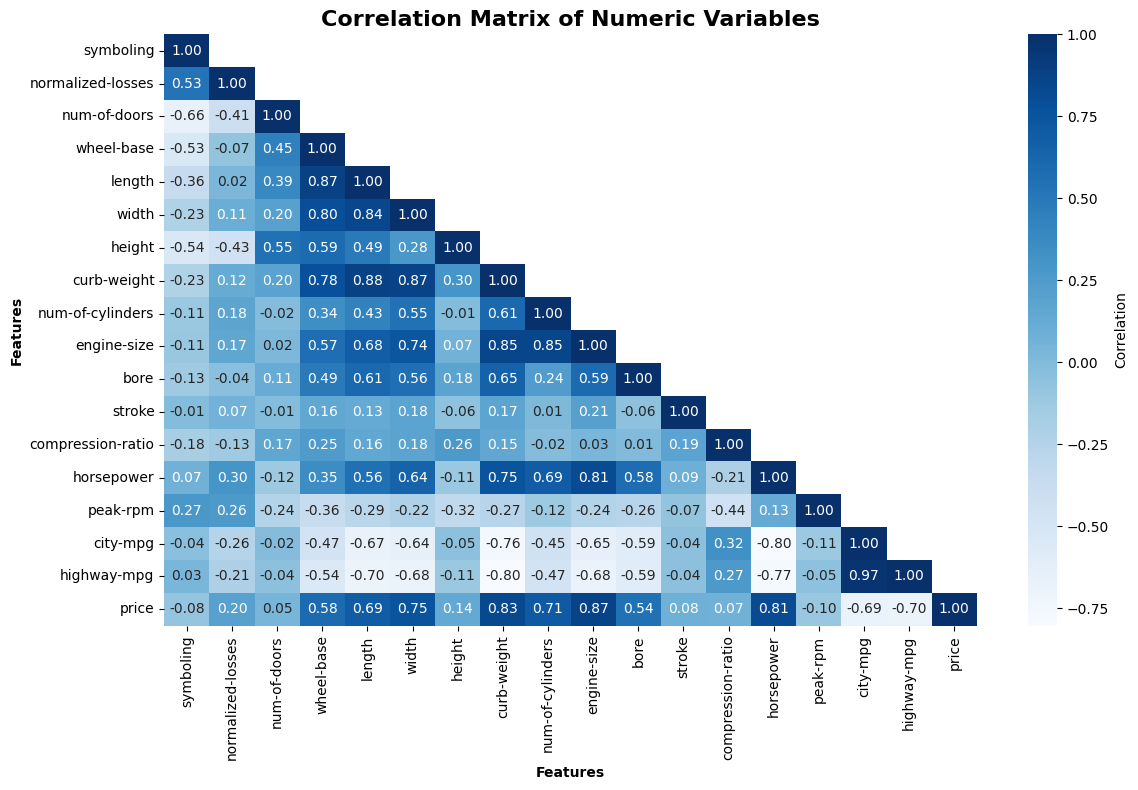

In [72]:
plot_correlation_heatmap(df)

In [73]:
features_b = [
    'make', 'engine-size', 'engine-type', 'highway-mpg',  # dropped city-mpg, curb-weight
    'fuel-system', 'horsepower', 'width', 'body-style'
]

run_xgboost_cv(df, features_b, False)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
Best CV RMSE: 2591.266416654351
Test RMSE: 2738.78
Test MAE: 1862.94
Test R²: 0.904
Adjusted R²: 0.880

Top Feature Importances:
make           0.290325
engine-size    0.192655
highway-mpg    0.137627
width          0.118015
engine-type    0.111896
horsepower     0.071637
fuel-system    0.064930
body-style     0.012916
dtype: float32


{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 50,
  'subsample': 1},
 'cv_rmse': 2591.266416654351,
 'rmse': 2738.780351637749,
 'mae': 1862.9360589748476,
 'r2': 0.9043779747343299,
 'adj_r2': 0.8804724684179124

In [74]:
run_xgboost_cv(df, features_b, True)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'subsample': 1}
Best CV RMSE: 2859.4824334326577
Test RMSE: 3028.75
Test MAE: 2052.79
Test R²: 0.881
Adjusted R²: 0.852

Top Feature Importances:
engine-size    0.308965
engine-type    0.177935
make           0.177344
highway-mpg    0.132001
horsepower     0.117409
fuel-system    0.042252
width          0.037034
body-style     0.007061
dtype: float32


{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 250,
  'subsample': 1},
 'cv_rmse': 2859.4824334326577,
 'rmse': 3028.7462888434943,
 'mae': 2052.788193121189,
 'r2': 0.8814225001791682,
 'adj_r2': 0.8517781252239

**FEATURE ENGINEERING - WITHOUT LLM HELP!!!**

In [75]:
df.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

To try to improve my models, I created a few new variables that I thought could give extra information about the cars:

Horsepower per Weight: This is basically the car’s power divided by its weight. It should help show which cars have better acceleration and overall performance.

MPG per Weight: Here, I took the miles per gallon (city) and divided by the car’s weight. I wanted to see which cars are surprisingly efficient (or inefficient) for their size.

MPG Ratio: This variable compares how efficient a car is in the city versus on the highway—something that can matter a lot for real-world drivers.
    
Engine Size per Cylinder: I made this to get an idea of how big each cylinder is, which might affect both power and fuel economy.

Car Volume: I calculated the volume (by multiplying length, width, and height) to get a  estimate of the car’s overall size, since that usually relates to price and maybe fuel use too.


In [76]:
df_feat = df.copy()

df_feat['horsepower_per_weight'] = df_feat['horsepower'] / df_feat['curb-weight']
df_feat['mpg_per_weight'] = df_feat['city-mpg'] / df_feat['curb-weight']
df_feat['mpg_ratio'] = df_feat['city-mpg'] / df_feat['highway-mpg']
df_feat['engine_size_per_cyl'] = df_feat['engine-size'] / df_feat['num-of-cylinders']
df_feat['car_volume'] = df_feat['length'] * df_feat['width'] * df_feat['height']


In [77]:
features = [col for col in df_feat.columns if col != 'price']

In [78]:
run_xgboost_cv(df_feat, features, True)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8}
Best CV RMSE: 1821.76605223038
Test RMSE: 1639.94
Test MAE: 1213.53
Test R²: 0.849
Adjusted R²: -3.685

Top Feature Importances:
mpg_per_weight    0.352477
width             0.153794
engine-size       0.091581
make              0.073223
curb-weight       0.072597
fuel-system       0.048293
horsepower        0.043111
drive-wheels      0.038295
length            0.022242
aspiration        0.019927
dtype: float32


{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'best_params': {'learning_rate': 0.03,
  'max_depth': 3,
  'n_estimators': 400,
  'subsample': 0.8},
 'cv_rmse': 1821.76605223038,
 'rmse': 1639.9430455555967,
 'mae': 1213.5255279541016,
 'r2': 0.8488637760053648,
 'adj_r2': -3.685222943

In [79]:
run_xgboost_cv(df_feat, features, False)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
Best CV RMSE: 2530.6798713366843
Test RMSE: 2579.20
Test MAE: 1658.25
Test R²: 0.915
Adjusted R²: 0.661

Top Feature Importances:
make                   0.191248
mpg_per_weight         0.179618
engine-size            0.172002
engine-type            0.137389
length                 0.083593
curb-weight            0.051495
highway-mpg            0.041716
engine_size_per_cyl    0.026252
body-style             0.019914
fuel-system            0.017944
dtype: float32


{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 50,
  'subsample': 1},
 'cv_rmse': 2530.6798713366843,
 'rmse': 2579.1960795268997,
 'mae': 1658.2473680449696,
 'r2': 0.9151967979935549,
 'adj_r2': 0.66078719197421

XGBoost handles missing values well, which is one of the reasons I chose to use it. Although it is possible to impute missing values or remove rows with missing data, in the context of this problem I believe it is better to make predictions using the data as it is.

However, the RMSE achieves, generally, a better value when missing values are not taken into account.

In practice, I would usually pick the model with the lower RMSE, because this means it makes more accurate predictions. 

But it iss also important to check R² to make sure the model isn’t missing big trends. Ideally, I want a model that does well on both metrics, but if I have to choose, I prioritize the model with lowest rmse value

Now, i will also choose the top 10 variables from the last xgboost

In [80]:
features = [
    'make',
    'mpg_per_weight',
    'engine-size',
    'engine-type',
    'length',
    'curb-weight',
    'highway-mpg',
    'engine_size_per_cyl',
    'body-style',
    'fuel-system'
]

In [81]:
run_xgboost_cv(df_feat, features, True)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
Best CV RMSE: 2602.4233910029025
Test RMSE: 2635.02
Test MAE: 1661.03
Test R²: 0.911
Adjusted R²: 0.882

Top Feature Importances:
engine-size            0.244912
make                   0.230341
mpg_per_weight         0.168582
engine-type            0.124385
curb-weight            0.073222
highway-mpg            0.051991
engine_size_per_cyl    0.041139
length                 0.028374
fuel-system            0.027732
body-style             0.009321
dtype: float32


{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 50,
  'subsample': 1},
 'cv_rmse': 2602.4233910029025,
 'rmse': 2635.02063117397,
 'mae': 1661.028594226372,
 'r2': 0.9114860808421708,
 'adj_r2': 0.8819814411228943,

In [82]:
run_xgboost_cv(df_feat, features, False)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
Best CV RMSE: 2602.4233910029025
Test RMSE: 2635.02
Test MAE: 1661.03
Test R²: 0.911
Adjusted R²: 0.882

Top Feature Importances:
engine-size            0.244912
make                   0.230341
mpg_per_weight         0.168582
engine-type            0.124385
curb-weight            0.073222
highway-mpg            0.051991
engine_size_per_cyl    0.041139
length                 0.028374
fuel-system            0.027732
body-style             0.009321
dtype: float32


{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 'best_params': {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 50,
  'subsample': 1},
 'cv_rmse': 2602.4233910029025,
 'rmse': 2635.02063117397,
 'mae': 1661.028594226372,
 'r2': 0.9114860808421708,
 'adj_r2': 0.8819814411228943,

When I used XGBoost with just the 10 most important variables, the RMSE actually got worse, which means that keeping more features (even if they seem less important on their own) can help XGBoost make better predictions.

The best model is the one using new features, but not removing any.

**FUTURE WORK**

In the future, I’d like to try out some other machine learning algorithms, especially Random Forest and LightGBM, to see how they compare with XGBoost. While XGBoost is a very popular and powerful method, it can sometimes be a bit sensitive to overfitting.

Random Forest might help in this regard because it builds a lot of decision trees independently and then averages their results, which tends to smooth out the noise present in data and makes the final predictions more robust.

LightGBM is another gradient boosting that I wanted to use.

I also plan to  analyze both the outputs of Cramér's V and eta-squared (η²). These statistics provide valuable insights into the strength of association between categorical variables (Cramér's V) and between categorical and numerical variables (eta-squared), which can support feature selection and interpretation of relationships within the data.